# Summarize Runs
Find the best model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from ase import units
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
model_to_tune = 'dft_mctbp-25000_ttm-100k'

## Gather outputs from runs
Get the configuration and test summary

In [3]:
complete_runs = [x.parent for x in Path('runs').glob('*/*/test_summary.json')]
print(f'Found {len(complete_runs)} completed runs')

Found 31 completed runs


In [4]:
def load_summary(path: Path) -> dict:
    """Load the summary of the run configuration and parameters
    
    Args:
        path: Path to the run
    Returns:
        Summary of inputs and results
    """
    
    # Load the configuration and summary
    output = {'path': path, 'starting_model': path.parent.name}
    output.update(json.loads((path / 'config.json').read_text()))
    output.update(json.loads((path / 'test_summary.json').read_text()))
    output['delta_energy'], output['delta_force'] = output['huber_deltas']
    
    # Get the best validation loss
    output['valid_force_loss'] = pd.read_csv(path / 'train_log.csv')['valid_loss_force'].min()
    return output

In [5]:
summary = pd.DataFrame(map(load_summary, complete_runs)).sort_values('force_rmse')
summary.head()

,path,starting_model,huber_deltas,num_epochs,batch_size,learning_rate,lr_patience,energy_weight,max_force,test_runtime,energy_mae,force_rmse,delta_energy,delta_force,valid_force_loss
13,runs/dft_md-25000_ttm-100k-large/n1024-lr3.0e-...,dft_md-25000_ttm-100k-large,"[0.1, 1]",1024,32,0.00003,8,0.1,10.0,3.219633,0.000461,0.100296,0.1,1,0.006593
28,runs/dft_md-25000_ttm-100k/n1024-lr3.0e-05-84e...,dft_md-25000_ttm-100k,"[0.1, 1]",1024,32,0.00003,64,0.1,10.0,3.134836,0.000479,0.100481,0.1,1,0.006662
26,runs/dft_md-25000_ttm-100k/n512-lr3.0e-05-6f2f...,dft_md-25000_ttm-100k,"[0.1, 1]",512,32,0.00003,64,0.1,10.0,3.254578,0.000519,0.102428,0.1,1,0.006837
20,runs/dft_md-25000_ttm-100k/n256-lr3.0e-05-f618...,dft_md-25000_ttm-100k,"[0.1, 1]",256,32,0.00003,64,0.1,10.0,3.356672,0.000510,0.105126,0.1,1,0.007140
30,runs/dft_md-25000_ttm-100k/n128-lr3.0e-05-307d...,dft_md-25000_ttm-100k,"[0.1, 1]",128,32,0.00003,64,0.1,10.0,3.574345,0.000560,0.108617,0.1,1,0.007534


## Evaluate the learning parameters
We need a low learning rate for fine tuning, but too low prevents adaquate learning. The effect of learning rate being too high appears in the first few epochs, so we'll do this test with only 8 epochs.

Only evaluate a single model type

In [6]:
to_eval = summary.query(f'starting_model=="{model_to_tune}"')

In [7]:
cutoff_subset = to_eval.query('num_epochs==16 and lr_patience==16').sort_values('learning_rate')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

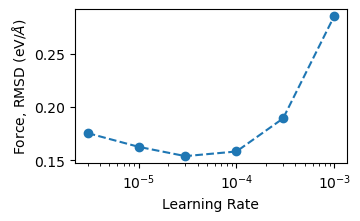

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogx(cutoff_subset['learning_rate'], cutoff_subset['force_rmse'], '--o')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

Check to make sure we don't overfit on the number of epochs

In [9]:
subset = to_eval.query('learning_rate==3e-5 and lr_patience==64').sort_values('num_epochs')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

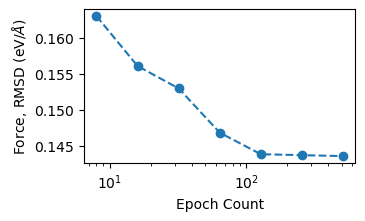

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogx(subset['num_epochs'], subset['force_rmse'], '--o')

ax.set_xlabel('Epoch Count')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

Text(0, 0.5, 'Test Loss')

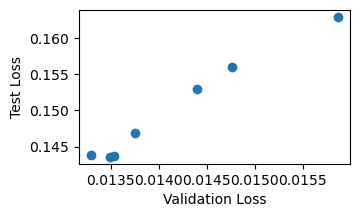

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(subset['valid_force_loss'], subset['force_rmse'], 'o')

ax.set_xlabel('Validation Loss')
ax.set_ylabel('Test Loss')

## Learning Curve
Figure out if we've completly converged wrt to number of epochs

In [12]:
best = to_eval.sort_values('force_rmse').iloc[0]
best

path                runs/dft_mctbp-25000_ttm-100k/n512-lr3.0e-05-5...
starting_model                               dft_mctbp-25000_ttm-100k
huber_deltas                                                 [0.1, 1]
num_epochs                                                        512
batch_size                                                         32
learning_rate                                                 0.00003
lr_patience                                                        64
energy_weight                                                     0.1
max_force                                                        10.0
test_runtime                                                 3.158279
energy_mae                                                    0.00098
force_rmse                                                   0.143601
delta_energy                                                      0.1
delta_force                                                         1
valid_force_loss    

In [13]:
log = pd.read_csv(best.path / 'train_log.csv')

Text(0, 0.5, 'Loss')

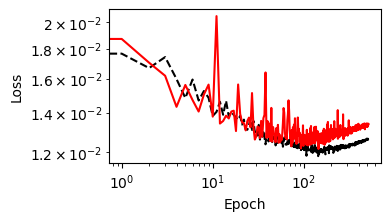

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.loglog(log['epoch'], log['train_loss_total'], '--k')
ax.loglog(log['epoch'], log['valid_loss_total'], '-r')


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

We don't finish converging even past 32 epochs. Need to set up a longer run

## Plot the Learning Data
Get an idea of what level of errors to expect

In [15]:
test_data = pd.read_csv(best.path / 'test_records.csv.gz').sort_values('n_atoms')
print(f'Loaded {len(test_data)} test records')

Loaded 2676 test records


Show the predicted vs actual

In [16]:
true_forces = np.concatenate(test_data['force_true'].apply(json.loads).apply(np.ravel))

In [17]:
ml_forces = np.concatenate(test_data['force_ml'].apply(json.loads).apply(np.ravel))

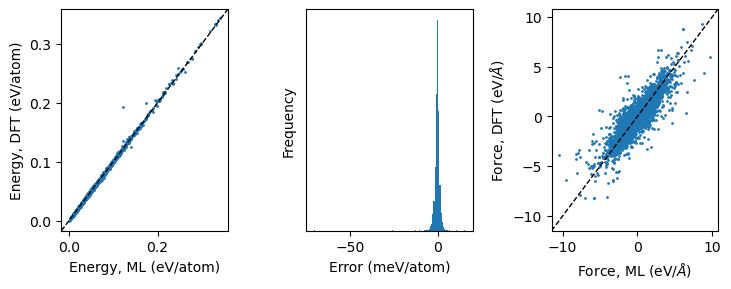

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 3.))

# Energy plot
ref = (test_data['energy_true'] / test_data['n_atoms']).min()
axs[0].scatter(test_data['energy_ml'] / test_data['n_atoms'] - ref, test_data['energy_true'] / test_data['n_atoms'] - ref, s=1)
axs[0].set_xlabel('Energy, ML (eV/atom)')
axs[0].set_ylabel('Energy, DFT (eV/atom)')

# Plot the energy histogram
err = (test_data['energy_ml'] - test_data['energy_true']) / test_data['n_atoms']
axs[1].hist(err * 1000, bins=128)
axs[1].set_xlabel('Error (meV/atom)')
axs[1].set_yticks([])
axs[1].set_ylabel('Frequency')

# Force plot
m = axs[2].scatter(ml_forces, true_forces, s=1)
axs[2].set_xlabel('Force, ML (eV/$\\AA$)')
axs[2].set_ylabel('Force, DFT (eV/$\\AA$)')

for ax in axs[[0, 2]]:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

fig.tight_layout()

## Save path to best model
Do these for every pretraining we are working from

In [19]:
best_model_dir = Path('best-models/')
for name, group in summary.groupby('starting_model'):
    best_model = group.sort_values('force_rmse').iloc[0]
    print(f'Best model for {name} is {best_model["path"].name}')
    
    # Save a link
    best_path = best_model_dir / name
    if best_path.is_symlink():
        best_path.unlink()
    best_path.symlink_to('..' / best_model.path)

Best model for dft_mctbp-25000_ttm-100k is n512-lr3.0e-05-5cfb9b6b
Best model for dft_md-25000_ttm-100k is n1024-lr3.0e-05-84eb7039
Best model for dft_md-25000_ttm-100k-large is n1024-lr3.0e-05-da9a257d
